In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'cmu serif'

page_width = 6.75 # aistats width

In [18]:
ds_name = 'cifar10'
results_path = f'../runs_final/{ds_name}/softmax'

In [19]:
seed_lst = [1071,3918,4420,5251,6637]
metrics_lst = ['cov', 'sys_acc', 'exp_acc', 'clf_acc', 'exp_acc_alone', 'clf_acc_alone', 'val_loss']

In [20]:
l2d_type_lst = ['pop']
p_out_lst = [0.1]
p_cntx_inclusion_lst = [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [21]:
results = {}
for l2d_type in l2d_type_lst:
    results[l2d_type] = {}
    
    if l2d_type != 'single':
        for p_cntx_inclusion in p_cntx_inclusion_lst:
            results[l2d_type][p_cntx_inclusion] = {}

            metrics_all = {metric:[[] for _ in range(len(p_out_lst))] for metric in metrics_lst}

            for ii,p_out in enumerate(p_out_lst):
                for seed in seed_lst:
                    fn_path = os.path.join(results_path, f'l2d_{l2d_type}', f'p{p_out}_seed{seed}', f'eval1.0_pc{p_cntx_inclusion}.log')

                    try:
                        line = open(fn_path).readline().rstrip()
                    except FileNotFoundError:
                        print(fn_path)
                    else:
                        line_split_grp = [line.split()[i:i+2] for i in range(0, len(line.split()),2)]
                        for [metric,val] in line_split_grp:
                            if metric=='cov':
                                cov = val.split('/')
                                metrics_all[metric][ii].append(100*int(cov[0])/int(cov[1]))
                            else:
                                metrics_all[metric][ii].append(float(val))

            for metric, vals in metrics_all.items():
                results[l2d_type][p_cntx_inclusion][metric] = np.vstack(vals)

In [22]:
l2d_type = 'single'
results[l2d_type] = {}
results[l2d_type][None] = {}

metrics_all = {metric:[[] for _ in range(len(p_out_lst))] for metric in metrics_lst}

for ii,p_out in enumerate(p_out_lst):
    for seed in seed_lst:
        fn_path = os.path.join(results_path, f'l2d_{l2d_type}', f'p{p_out}_seed{seed}', f'eval1.0.log')

        try:
            line = open(fn_path).readline().rstrip()
        except FileNotFoundError:
            print(fn_path)
        else:
            line_split_grp = [line.split()[i:i+2] for i in range(0, len(line.split()),2)]
            for [metric,val] in line_split_grp:
                if metric=='cov':
                    cov = val.split('/')
                    metrics_all[metric][ii].append(100*int(cov[0])/int(cov[1]))
                else:
                    metrics_all[metric][ii].append(float(val))

for metric, vals in metrics_all.items():
    results[l2d_type][None][metric] = np.vstack(vals)

In [23]:
# read in pretrained classifier
pretrained_results_path = f'../pretrained/{ds_name}'
l2d_type = 'pretrained'
results[l2d_type] = {}
results[l2d_type][None] = {}

pretrained_metrics_lst = ['clf_acc','val_loss']
metrics_all = {metric:[] for metric in pretrained_metrics_lst}

for seed in seed_lst:
    fn_path = os.path.join(pretrained_results_path, f'seed{seed}', f'eval.log')

    try:
        line = open(fn_path).readline().rstrip()
    except FileNotFoundError:
        print(fn_path)
    else:
        line_split_grp = [line.split()[i:i+2] for i in range(0, len(line.split()),2)]
        for [metric,val] in line_split_grp:
            if metric=='cov':
                cov = val.split('/')
                metrics_all[metric].append(int(cov[0])/int(cov[1]))
            else:
                metrics_all[metric].append(float(val))
                
for metric, vals in metrics_all.items():
    results[l2d_type][None][metric] = np.vstack(vals)

In [24]:
c_red = mpl.colormaps['Set1'](0)
c_blue = mpl.colormaps['Set1'](1)

In [25]:
metrics_to_text = {
    'cov':'Coverage (\%)',
    'sys_acc': 'System accuracy (\%)',
    'exp_acc': 'Expert accuracy\non deferred examples (\%)',
    'clf_acc': 'Classifier accuracy\n on non-deferred examples (\%)',
    'clf_acc_alone': 'Classifier accuracy\n on all examples (\%)',
    'val_loss': 'Test loss'
}

In [26]:
l2d_type_to_text = {
    'single': 'Single-expert',
    'pop': 'Population',
    # 'pop_attn': 'Population w/ attention'
    'pop_attn': 'Population + Attn',
    'single_finetune': 'Single-expert (finetune)',
    'pretrained': 'non-L2D classifier'
}

In [27]:
dataset_to_yticks_cov = {
    'cifar10' : np.arange(93,100,2), #np.arange(92,101,2),
}

dataset_to_yticks_sysacc = {
    'cifar10' : np.arange(87,91,1),
}

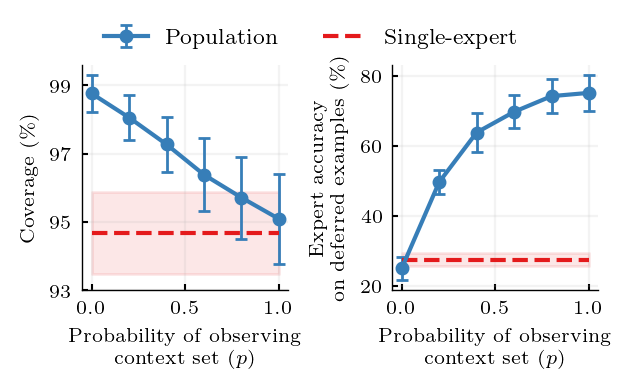

In [28]:
fig,axs = plt.subplots(1,2,figsize=(3.,1.6), constrained_layout=True)

p_cntxt_show = [0,0.2,0.4,0.6,0.8,1.0]

metric_to_col = {'single':c_red,'pop':c_blue, 'pretrained':'g'}
metric_to_marker = {'single':'s-','pop':'o-'}
errbar_args={'capsize':2, 'markersize':4, 'elinewidth':1, 'capthick':1, 'lw':1.5} # 'fmt':'o-'

fs_ax_lbl=7
fs_ax_ticks = 7
fs_ax_title = 8

l2d_type = 'pop'
for ax,metric in zip(axs,['cov', 'exp_acc']):
    res_all = np.vstack([results['pop'][pp][metric] for pp in p_cntxt_show])
    metric_mean = np.mean(res_all, axis=1)
    metric_std = np.std(res_all, axis=1)
    
    ax.errorbar(np.array(p_cntxt_show), metric_mean, yerr=metric_std, label=l2d_type_to_text[l2d_type], \
                c=metric_to_col[l2d_type], fmt=metric_to_marker[l2d_type], **errbar_args)
    
    res_single = results['single'][None][metric]
    res_single_mean = np.mean(res_single)
    res_single_std = np.std(res_single)
    ax.plot(np.array(p_cntxt_show), [res_single_mean]*len(p_cntxt_show), color=metric_to_col['single'], ls='--', label=l2d_type_to_text['single'])
    ax.fill_between(np.array(p_cntxt_show), [(res_single_mean-res_single_std)]*len(p_cntxt_show), \
                    [(res_single_mean+res_single_std)]*len(p_cntxt_show), alpha=0.1, color=metric_to_col['single'])
    
    ax.set_xlabel('Probability of observing' + '\n' +  'context set ($p$)', fontsize=fs_ax_lbl)
    ax.set_ylabel(metrics_to_text[metric], fontsize=fs_ax_lbl)
    ax.grid(True, alpha=0.15)
    ax.set_xticks([0,0.5,1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(direction='in', labelsize=fs_ax_ticks,length=2., width=0.75)
    [x.set_linewidth(.5) for x in ax.spines.values()]
    
# # show non-L2D classifier performance
# res_pretrained = results['pretrained'][None]['clf_acc']
# res_pretrained_mean = np.mean(res_pretrained)
# res_pretrained_std = np.std(res_pretrained)
# axs[1].plot(np.array(p_cntxt_show), [res_pretrained_mean]*len(p_cntxt_show), color=metric_to_col['pretrained'], ls='--', label=l2d_type_to_text['pretrained'])
# axs[1].fill_between(np.array(p_cntxt_show), [(res_pretrained_mean-res_pretrained_std)]*len(p_cntxt_show), \
#                     [(res_pretrained_mean+res_pretrained_std)]*len(p_cntxt_show), alpha=0.1, color=metric_to_col['pretrained'])
    
# manual setting of yticks
axs[0].set_yticks(dataset_to_yticks_cov[ds_name]);
# axs[1].set_yticks(dataset_to_yticks_sysacc[ds_name]);

handles, labels = axs[0].get_legend_handles_labels()
order = [1,0] #[2,0,1]
leg = fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], \
                 fontsize=fs_ax_title,frameon=False,ncol=3,loc='upper center',bbox_to_anchor=(0.5, 1.15))
leg.get_frame().set_linewidth(0.5)

# fig.savefig(f'context_dropping_testtime.pdf', dpi=600, facecolor='white', bbox_inches='tight', pad_inches=0.01)